<a href="https://colab.research.google.com/github/MChamith/SpatioAE/blob/master/trainae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/MChamith/SpatioAE

Cloning into 'SpatioAE'...
remote: Enumerating objects: 80, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 7222 (delta 46), reused 5 (delta 2), pack-reused 7142
Receiving objects: 100% (7222/7222), 275.78 MiB | 11.81 MiB/s, done.
Resolving deltas: 100% (100/100), done.
Checking out files: 100% (7207/7207), done.


In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

gpg: keybox '/tmp/tmpkjozxoll/pubring.gpg' created
gpg: /tmp/tmpkjozxoll/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1
E: Unable to locate package google-drive-ocamlfuse


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

/bin/bash: google-drive-ocamlfuse: command not found


In [0]:

from keras.layers import Input, Dense, Conv3D, MaxPooling3D, UpSampling3D, Activation, BatchNormalization
from keras.models import Model,load_model
from keras.preprocessing import image
from keras import backend as K
from keras.optimizers import Adam
from keras.utils import Sequence
import cv2
import numpy as np
import os
from tqdm import tqdm
import fnmatch
import scipy.misc
from keras.models import load_model
from keras import regularizers

In [0]:
from keras.layers import Input, Dense, Conv3D, MaxPooling3D, UpSampling3D, Activation, BatchNormalization
from keras.models import Model
from keras.preprocessing import image
from keras import backend as K
import cv2
import numpy as np
import os
from tqdm import tqdm
import fnmatch
import scipy.misc
from keras.models import load_model
import re
TRAIN_DIR ='gdrive/My Drive/Data/DEIE/frames'
TEST_DIR = 'gdrive/My Drive/Data/datasets/Test013'
IMG_SIZE = 128



def create_training_set():
  
  train_data = []
  matches = []
  partition = {'train':[]}
  
  for root, dirnames, filenames in tqdm(os.walk(TRAIN_DIR)):
    
    alist= dirnames
    blist = filenames
    alist.sort(key=natural_keys)
    blist.sort(key=natural_keys)
    
    for filename in fnmatch.filter(filenames, "*.jpg"):
     
      path = os.path.join(root, filename)
      partition['train'].append(path)
      
#       img = image.load_img(path, target_size=(128,128), grayscale = True)
#       img_array = image.img_to_array(img)
#       train_data.append(np.array(img_array))
          
#   np.save('training_data.npy' , train_data)

  return partition

def atof(text):
    try:
        retval = float(text)
    except ValueError:
        retval = text
    return retval

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    float regex comes from https://stackoverflow.com/a/12643073/190597
    '''
    return [ atof(c) for c in re.split(r'[+-]?([0-9]+(?:[.][0-9]*)?|[.][0-9]+)', text) ]

      
    


def create_test_set():
  
  test_data = []
  matches = []
  
  for root, dirnames, filenames in tqdm(os.walk(TEST_DIR)):
   
    alist= dirnames
    blist = filenames
    alist.sort(key=natural_keys)
    blist.sort(key=natural_keys)

    for filename in fnmatch.filter(filenames, "*.tif"):
      path = os.path.join(root, filename)
      img = image.load_img(path, target_size=(128,128), grayscale = True)
      img_array = image.img_to_array(img)
      test_data.append(np.array(img_array))
          
  np.save('test_data13.npy' , test_data)
  
  return test_data  

In [0]:
VAL_DIR = 'gdrive/My Drive/Data/DEIE/ValidationData'
def create_validation_set():
  
 
  val_set = {'validation':[]}
  
  for root, dirnames, filenames in tqdm(os.walk(VAL_DIR)):
    
    alist= dirnames
    blist = filenames
    alist.sort(key=natural_keys)
    blist.sort(key=natural_keys)
    
    for filename in fnmatch.filter(filenames, "*.jpg"):
     
      path = os.path.join(root, filename)
      val_set['validation'].append(path)
      

  return val_set

def atof(text):
    try:
        retval = float(text)
    except ValueError:
        retval = text
    return retval

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    float regex comes from https://stackoverflow.com/a/12643073/190597
    '''
    return [ atof(c) for c in re.split(r'[+-]?([0-9]+(?:[.][0-9]*)?|[.][0-9]+)', text) ]

      
    


In [0]:
def create_cuboid(input_imgs):
  
  win_size = 16
  m = input_imgs.shape[0]
  h = input_imgs.shape[1]
  w = input_imgs.shape[2]
  c = input_imgs.shape[3]
  
#   a = []                                    # a python list to hold the windows
  for i in range(0, input_imgs.shape[0]-win_size+1):
    window = input_imgs[i:i+win_size,:,:,:].reshape((-1,h,w,c)) # each individual window
    np.save('gdrive/My Drive/Data/data_ped1/id-'+ str(i)+ '.npy', window)
#     a.append(window)
#     print('i = ' + str(i))
   
#   cuboid = np.hstack(a)
#   np.save('hyper_cuboid_win16.npy' , a)
#   return a

  
  

In [0]:
def create_test_cuboid(input_imgs):
  
  win_size = 16
  m = input_imgs.shape[0]
  h = input_imgs.shape[1]
  w = input_imgs.shape[2]
  c = input_imgs.shape[3]
  
  t = []                                    # a python list to hold the windows
  for i in range(0, input_imgs.shape[0]-win_size+1):
    window = input_imgs[i:i+win_size,:,:,:].reshape((-1,h,w,c)) # each individual window
    t.append(window)
   
#   cuboid = np.hstack(a)
  np.save('test_hyper_cuboid_win16_13.npy' , t)
  return t

In [0]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs,  batch_size=1, dim=(16,128,128), n_channels=1,
                 shuffle=False):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
#         print(index)
        indexes = self.indexes[index:index+16]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
#         print('list_Ids ' + str(list_IDs_temp))
        # Generate data
        X,Y = self.__data_generation(list_IDs_temp)

        return X,Y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        Y = np.empty((self.batch_size, *self.dim, self.n_channels))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
#             print('i is '+str(i) + 'Id is '+str(ID))
            img = image.load_img(ID, target_size=(128,128), grayscale = True)
            img_arry = image.img_to_array(img)
            X[:,i,] = np.array(img_arry)
            Y[:,i,] = X[:,i,]
        X = X.astype('float32')/255
        Y = Y.astype('float32')/255
        return X,Y


In [14]:
partition = create_training_set()
validation = create_validation_set()
params = {'dim': (16,128,128),
          'batch_size': 1,
          'n_channels': 1,
          'shuffle': False}
train_gen = DataGenerator(**params, list_IDs=partition['train'])
validation_gen = DataGenerator(**params, list_IDs=validation['validation'])

20it [00:00, 63.33it/s]
10it [00:00, 77.78it/s]


In [0]:
import json


with open('gdrive/My Drive/Final year project/partition/train_dictionary.json', 'w') as f: 
  json.dump(partition)
   
with open('gdrive/My Drive/Final year project/partition/train_dictionary.json', 'w') as f: 
  json.dump(partition)


In [12]:
print(len(validation['validation']))

7600


In [0]:

def model_autoencoder():
  
  input_img  = Input(shape = (16,128,128,1))  #channel last
  
  x = Conv3D(filters = 32, kernel_size = (3,3,3),strides = (1,1,1) , padding ='same' , kernel_initializer = 'glorot_uniform',kernel_regularizer=regularizers.l2(0.01))(input_img)
  x = BatchNormalization(axis = 4)(x)
  x = Activation('relu')(x)
  x = MaxPooling3D(pool_size = (2,2,2), strides = (2,2,2))(x)
  print("layer one conv " + str(x.shape))
  
  x = Conv3D(filters = 48, kernel_size = (3,3,3),strides = (1,1,1) , padding ='same' ,kernel_regularizer=regularizers.l2(0.01), kernel_initializer = 'glorot_uniform')(x)
  x = BatchNormalization(axis = 4)(x)
  x = Activation('relu')(x)
  x = MaxPooling3D(pool_size = (2,2,2), strides = (2,2,2))(x)
  print("layer two conv " + str(x.shape))
  
 
  x = Conv3D(filters = 64, kernel_size = (3,3,3),strides = (1,1,1) , padding ='same' , kernel_initializer = 'glorot_uniform',kernel_regularizer=regularizers.l2(0.01))(x)
  x = BatchNormalization(axis = 4)(x)
  x = Activation('relu')(x)
  x = MaxPooling3D(pool_size = (2,2,2), strides = (2,2,2), padding= 'same')(x)
  print("layer three conv " + str(x.shape))
  
  x = Conv3D(filters = 64, kernel_size = (3,3,3),strides = (1,1,1) , padding ='same' , kernel_initializer = 'glorot_uniform',kernel_regularizer=regularizers.l2(0.01))(x)
  x = BatchNormalization(axis = 4)(x)
  x = Activation('relu')(x)
  encoded = MaxPooling3D(pool_size = (1,1,1), strides = (1,1,1))(x)
  print("layer four conv " + str(encoded.shape))
  
  
  ## decoder branch
  
  x = Conv3D(filters = 48, kernel_size = (3,3,3),strides = (1,1,1) , padding ='same' , kernel_initializer = 'glorot_uniform',kernel_regularizer=regularizers.l2(0.01))(encoded)
  x = UpSampling3D(size = (2,2,2))(x)
  x = BatchNormalization(axis = 4)(x)
  x = Activation('relu')(x)
  print("layer one deconv " + str(x.shape))
 
  x = Conv3D(filters = 32, kernel_size = (3,3,3),strides = (1,1,1) , padding ='same' , kernel_initializer = 'glorot_uniform',kernel_regularizer=regularizers.l2(0.01))(x)
  x = UpSampling3D(size = (2,2,2))(x)
  x = BatchNormalization(axis = 4)(x)
  x = Activation('relu')(x)
  print("layer two deconv " + str(x.shape))
  
  x = Conv3D(filters = 32, kernel_size = (3,3,3),strides = (1,1,1) , padding ='same' , kernel_initializer = 'glorot_uniform',kernel_regularizer=regularizers.l2(0.01))(x)
  x = UpSampling3D(size = (2,2,2))(x)
  x = BatchNormalization(axis = 4)(x)
  x = Activation('relu')(x)
  print("layer three deconv " + str(x.shape))
  decoded = Conv3D(filters = 1, kernel_size = (3,3,3), strides = (1,1,1), padding = 'same', activation = 'sigmoid',kernel_regularizer=regularizers.l2(0.01))(x)
  print("output" + str(decoded.shape))

  
  
  autoencoder = Model(input_img, decoded)
  
  return autoencoder
  

In [0]:
autoencoder = model_autoencoder()
autoencoder.compile(optimizer = 'adam' , loss = 'mean_squared_error', metrics = ['acc'])

layer one conv (?, 8, 64, 64, 32)
layer two conv (?, 4, 32, 32, 48)
layer three conv (?, 2, 16, 16, 64)
layer four conv (?, 2, 16, 16, 64)
layer one deconv (?, 4, 32, 32, 48)
layer two deconv (?, 8, 64, 64, 32)
layer three deconv (?, 16, 128, 128, 32)
output(?, 16, 128, 128, 1)


In [0]:
autoencoder = load_model('gdrive/My Drive/Final year project/DEIE_Models/deieModel2-02.h5')

In [16]:
from keras.callbacks import Callback, ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        
history = LossHistory() 
file_path = 'gdrive/My Drive/Final year project/DEIE_Models/deieModel3-{epoch:02d}.h5'
check_pointer = ModelCheckpoint(filepath= file_path)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2 ,min_lr=0.00001,
                              verbose=1 )

# img_cuboids = np.load('hyper_cuboid_win16.npy')       
model_history = autoencoder.fit_generator(generator = train_gen, 
                                          epochs =5,
                                          validation_data = validation_gen,
                                          callbacks=[history, check_pointer,reduce_lr], 
                                          shuffle = False)  


SyntaxError: ignored

In [0]:
# create_training_set()
# input_imgs = np.load('training_data.npy')
# create_cuboid(input_imgs)
img_cuboids = np.load('gdrive/My Drive/Data/hyper_cuboid_new_win16.npy')
print("hyper cuboid loaded")
# img_cuboids = img_cuboids.astype('float32') / 255.
# print("data normalized")
# K.clear_session()
# autoencoder = model_autoencoder()
# autoencoder.compile(optimizer = 'adam' , loss = 'mean_squared_error', metrics = ['acc'])
# print("model compiled")
# autoencoder.fit(img_cuboids,img_cuboids,  epochs =10, batch_size= 32)
# print("model fitted")
  
    

hyper cuboid loaded


In [0]:
autoencoder.save('deie1.h5')
autoencoder.save('gdrive/My Drive/Data/new_model_win16_iter1.h5')


In [0]:
autoencoder = load_model('gdrive/My Drive/Final year project/DEIE_Models/deieModel-02.h5')

In [0]:
train_loss = np.array(history.losses)
# train_loss = train_loss[16965-6785:16965]
# train_loss_normed = np.linalg.norm(train_loss)
min_ex = min(train_loss)
max_ex = max(train_loss)

print('minimum loss = ' + str(min_ex) + 'maximum loss= ' + str(max_ex)+ 'train losss = '+str(train_loss.shape))

minimum loss = 0.0006428565maximum loss= 0.0050993245train losss = (1697,)


In [0]:
get_test_data = create_test_set()
test_imgs = np.load('test_data13.npy')
test_imgs = test_imgs.astype('float32') / 255.
create_test_cuboid(test_imgs)
test_cuboid = np.load('test_hyper_cuboid_win16_13.npy')

print('data loaded')




1it [01:11, 71.95s/it]


data loaded


In [0]:
print(test_cuboid.shape)

(185, 16, 128, 128, 1)


In [0]:
for i in range(1):
  for j in range(16):
    scipy.misc.imsave('drive/My Drive/Data/blah'+str(j)+'.png', np.squeeze(test_cuboid[i][j], axis = 2))
#   sq_img = np.squeeze(test_cuboid[n][1], axis = 2)
#   sq_img = sq_img*255
#   sq_img = sq_img.astype('uint8')

#   dec_img = np.squeeze(decode_imgs[n][1], axis = 2)
#   dec_img = dec_img*255
#   dec_img = dec_img.astype('uint8')

  
#   scipy.misc.imsave('drive/Data/dec'+str(n)+'.png', dec_img)
  

In [0]:
decode_imgs = autoencoder.predict(test_cuboid)

In [0]:
print(np.squeeze(decode_imgs[1][1]))
print(np.squeeze(test_cuboid[1][1]))

[[0.3665918  0.31407773 0.4027053  ... 0.33415452 0.15355128 0.2725734 ]
 [0.28767076 0.25165272 0.4176241  ... 0.33526462 0.19010405 0.32217863]
 [0.3285036  0.36008832 0.26042366 ... 0.3353285  0.29230455 0.4493007 ]
 ...
 [0.41672572 0.41849038 0.41418377 ... 0.6470401  0.66060466 0.75101554]
 [0.43709612 0.44734138 0.4424473  ... 0.6860009  0.67404884 0.7712986 ]
 [0.439424   0.4661526  0.475611   ... 0.72254467 0.70244664 0.7338248 ]]
[[0.34901962 0.30588236 0.3882353  ... 0.31764707 0.16078432 0.26666668]
 [0.2509804  0.26666668 0.41568628 ... 0.32156864 0.1764706  0.31764707]
 [0.30980393 0.36862746 0.2627451  ... 0.34117648 0.2784314  0.49803922]
 ...
 [0.40784314 0.4        0.40784314 ... 0.654902   0.6627451  0.7137255 ]
 [0.44705883 0.4627451  0.45490196 ... 0.67058825 0.64705884 0.72156864]
 [0.4627451  0.4627451  0.4745098  ... 0.69411767 0.6666667  0.7372549 ]]


In [0]:
real_img = np.load('test_data.npy')
	diff=x1-x2
	a,b,c,d,e=diff.shape
	n_samples=a*b*c*d*e
	sq_diff=diff**2
	Sum=sq_diff.sum()
	dist=np.sqrt(Sum)
	mean_dist=dist/n_samples

	return mean_dist

In [0]:
def calculate_score(input_img, reconstructed_img):
  diff = input_img - reconstructed_img
  a,b,c=diff.shape
  n_samples=a*b*c
  sq_diff=diff**2
  Sum=sq_diff.sum()
  dist=np.sqrt(Sum)
  mean_dist=dist/n_samples
  return mean_dist
  

In [0]:
def calculate_costs(img_size, win_size):
  
  input_size = img_size+win_size
  costs = np.zeros(img_size+win_size-1, dtype= float)
#   if img_size+win_size > num_input:
#     break
    
  for i in range(0, img_size):
    for k in range(win_size):
      temp = np.squeeze(test_cuboid[i])-np.squeeze(decode_imgs[i][k])
      costs[i+k]= np.linalg.norm(temp)
			
  
  np.save('costs.npy',costs)
  return costs
    
  
  
  
  

In [0]:
def calculate_costs_tset(img_size, win_size):
  
  input_size = img_size+win_size
  costs = np.zeros(img_size+win_size-1, dtype= float)
#   if img_size+win_size > num_input:
#     break
    
  for i in range(0, img_size):
    for k in range(win_size):
#       temp = np.squeeze(test_cuboid[i][k])-np.squeeze(decode_imgs[i][k])
      temp = calculate_score(test_cuboid[i][k],decode_imgs[i][k])
      costs[i+k]= np.linalg.norm(temp)
			
  
  np.save('test_costs_test.npy',costs)
  return costs
    

In [0]:
print(np.linalg.norm(np.squeeze(decode_imgs[1][2])-np.squeeze(test_cuboid[1][2])))

7.740723


In [0]:
calculate_costs(test_cuboid.shape[0],16)
cost_val = np.load('costs.npy')
print(cost_val)


[45.56664276 45.96834564 46.34439087 46.65560532 46.8166008  46.82033157
 46.71285629 46.45462036 46.31354141 46.21473694 46.06408691 46.08926773
 46.07445908 46.02218628 45.87091827 45.6737442  45.54132843 45.39936066
 45.3204422  45.20293808 44.95856094 44.69622803 44.54750824 44.39567947
 44.44113922 44.50605774 44.34347534 44.15657806 44.23666382 44.31383896
 44.46660995 44.75284576 44.93671036 44.88977432 44.72796249 44.44228363
 44.22872543 43.83961105 43.57062149 43.56618118 43.69816971 43.9232254
 44.15531921 44.12902069 43.99019241 43.62126923 43.17108154 42.71552277
 42.47335434 42.33099747 42.35348129 42.36640167 42.45692062 42.74806976
 43.12636566 43.47488022 43.67025757 43.52616882 43.27047348 43.28398895
 43.41221619 43.51791    43.73514175 43.78274155 43.87152863 43.81866074
 43.90690994 44.1456871  44.20573044 44.18507004 44.27777481 44.47150421
 44.53787994 44.15016174 43.85331726 43.7754097  43.81142426 43.60419083
 43.66697311 43.67214584 43.69627762 43.66583633 43.

In [0]:
print(cost_val)

In [0]:
cost_val1 = np.load('test_costs_win8_iter2.npy')

In [0]:
score = cost_val - min(cost_val)
score = 1 - (score/max(score))
print('maximum score = ' +str(max(score))+ 'min score = ' + str(min(score)))

maximum score = 1.0min score = 0.0


In [0]:
print(score)

[0.09814727 0.06823592 0.04023507 0.01706161 0.00507366 0.00479586
 0.01279862 0.03202723 0.04253216 0.04988928 0.06110689 0.05923189
 0.06033456 0.06422687 0.07549049 0.09017235 0.10003221 0.11060333
 0.11647971 0.12522923 0.14342589 0.16295956 0.17403344 0.18533882
 0.18195383 0.1771199  0.18922602 0.20314265 0.19717935 0.19143278
 0.18005724 0.15874373 0.14505291 0.14854783 0.16059657 0.18186861
 0.19777045 0.22674445 0.24677379 0.24710442 0.23727637 0.22051841
 0.20323638 0.20519461 0.21553195 0.24300249 0.27652409 0.31044563
 0.32847782 0.33907791 0.33740374 0.33644167 0.3297015  0.30802213
 0.27985369 0.25390281 0.23935475 0.25008379 0.26912322 0.26811684
 0.25856887 0.25069876 0.23452338 0.23097903 0.22436782 0.22830444
 0.22173328 0.2039536  0.19948269 0.20102109 0.19411817 0.17969281
 0.17475038 0.20362041 0.22572387 0.23152497 0.22884328 0.24427417
 0.23959931 0.23921414 0.23741726 0.23968396 0.23849919 0.2302692
 0.21374558 0.1926451  0.17152871 0.144551   0.13640735 0.11198

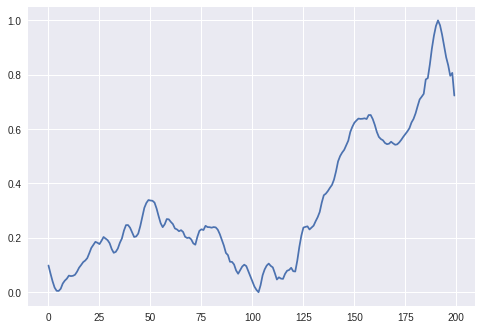

In [0]:
import matplotlib.pyplot as plt
# plt.plot(score1)
plt.plot(score)
# plt.legend(['epoch 47', 'epoch 35'], loc='upper left')
plt.show()


In [0]:
import matplotlib.pyplot as plt
from PIL import Image

for n in range(100,125):
  sq_img = np.squeeze(test_cuboid[n][1], axis = 2)
  sq_img = sq_img*255
  sq_img = sq_img.astype('uint8')

  dec_img = np.squeeze(decode_imgs[n][1], axis = 2)
  dec_img = dec_img*255
  dec_img = dec_img.astype('uint8')

  scipy.misc.imsave('drive/Data/testimage'+str(n)+'.png', sq_img)
  scipy.misc.imsave('drive/Data/dec'+str(n)+'.png', dec_img)


# plt.imshow(sq_img)

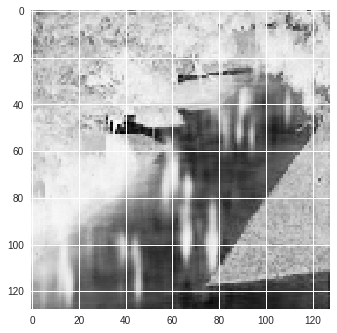

In [0]:
plt.imshow(np.squeeze(decode_imgs[1][1], axis = 2))
  

In [0]:
autoencoder_model.evaluate(test_cuboid, test_cuboid)


193/193 [==============================] - 4s 21ms/step


[0.00776640931385632, 1.1977754108646373e-05, 0.05647316436075794]

In [0]:
import pydot
import graphviz
from keras.utils import plot_model
plot_model(autoencoder, to_file='model.png',show_shapes=True)

In [0]:
!apt-get install -q graphviz

Reading package lists...
Building dependency tree...
Reading state information...
graphviz is already the newest version (2.38.0-16ubuntu2).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
